# Graph generation, pruning and minor-embedding of a JSS problem 


In this notebook is demonstrated 2 steps of the workflow needed to resolve a JSS problem using quantum annealing.

* A preliminar step would be to find the QUBO formulation of the target problem, in this instance the JSS already comes in the shape of a QUBO instance.

* The first step is to generate the graph representation of the problem, assigning a node to every variable and then connecting them with edges corresponding to the $x_ix_j$ terms in the constraints.
After that is convinient to prune the graph of useless nodes and edges exploiting the problem structure.

* The second section of the notebook present 2 ways of performing the minor-embedding of the logical graph on the target(hardware) graph.
The first method is given by the D'Wave API and is based on euristics while the second is an IP approach to the problem, expressing the proprieties of the desired graph as constraints it is possible to minimize the number of qubit used to embed the problem.


NOTE: the cells with the functions definitions are here only for completeness purpose, everything is included in 'ip_embed.py' and 'jss_graph.py', so the import of those modules is enough to run the notebook

# IMPORTS

In [126]:
!pip install networkx
!pip install dwave-ocean-sdk
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import copy

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

from itertools import product
from dwave.embedding import pegasus
import dwave.inspector
import minorminer
import dwave_networkx as dnx

import gurobipy as gb
from gurobipy import GRB

#from jss_graph import *
#from ip_embed import *

In [236]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Uni/gurobi.lic','r') as f:
  lic = f.read()

ls = lic.split('\n')
access_id = ls[3].split('=')[1]
secret = ls[4].split('=')[1]
id = int(ls[5].split('=')[1])

params = {
"WLSACCESSID": access_id,
"WLSSECRET": secret,
"LICENSEID": id,
}
env = gb.Env(params=params)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2381296
Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it


# Graph generation and pruning

## Functions

### Graph construction

In [4]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

In [5]:


def get_variables(instance):

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    variables = np.zeros((n_machines, n_jobs, instance['timespan']))
    
    return variables


Here we start building the backbone of the graphe inserting every a node for every variable.
The positions of the nodes are set in a way that organizes them in the following way:

1 block for every machine. 

For every machine a column for every job.

Every block has a number of lines equal to the timespan considered.


In [6]:
def build_graph(instance):
    graph = nx.Graph()
    job_groups = {}

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

    #this dictionary {job:(nodes of task1), (nodes of task2), (nodes of task3)} is needed for visualiziong the graph
    task_groups = {}

    m_seq = {}

    for job in range(n_jobs):
        m_seq[job] = []
        for task in instance[job]:
                m_seq[job].append(task[0])

    for job in m_seq:
        task_groups[job] = []
        
        for m in m_seq[job]:
                tmp = []

                for node in job_groups[job]:
                    if m == node[0]:
                            tmp.append(node)

                task_groups[job].append(tmp)


    #this dictionary {node:position} is needed for visualizing the graph
    pos_dict = {}

    for n in graph.nodes:
        pos_dict[n] = graph.nodes[n]['pos']


    return graph, task_groups, pos_dict

### Edge Constraints Generation

This function generates the edges relative to the START ONLY ONCE constraint.

The mathematical formulation of this constraint is:
$$ \sum_i(\sum_t x_{i,t} -1)^2 $$

And so we have an edge for every pair $x_{i,t}, x_{i,p}$ where $p \neq t$

This kind of edges are orange in the final plots

In [7]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

This function generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:

$$ \sum_{ k_{n-1}<i<k_n \atop t+p_i > t'}  x_{i,t}x_{i+1,t'}$$

In [8]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in range(n_jobs):
        for i in range(n_machines-1):
            task = instance[job][i]
            m = task[0]
            p = task[1]
            for t in range(timespan):
                t_max = min(t + p, timespan)
                for t_p in range(t_max):
                    task_p = instance[job][i+1]
                    m_p = task_p[0]
                    p_p = task_p[1]

                    edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

This set of functions generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:
$$\sum_{(i,t,k,t')\in R_m} x_{i,t}x_{k,t'} $$

where $R_m = A_m \cup B_m$ (here $B_m is not yet present, it is needed for the generalization where p=0)

And $A_m = \{(i,t,k,t'): (i,k) \in I_M \times I_M, \\ \qquad \qquad i \neq j,\\ \qquad \qquad 0\leq t,\\ \qquad \qquad t'\leq T,\\ \qquad \qquad 0<t'-t<p_i  \}$

where $I_M$ is the set of all tasks that need the machine M to run.

In [9]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for task in instance[job]:
            if task[0] == m:
                I_m.add((m,job))
    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)
    '''
    tmp = list(I_mx)
    for e in tmp:
        if (e[1], e[0]) in I_mx:
            I_mx.remove(e)
    '''
            
    return I_mx

In [10]:
def A_set(instance, m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_mx = I_set(instance, m)

    A_m = set()

    for e in I_mx:
        
        job = e[0][1]
        for t in instance[job]:
            if t[0] == m:
                p = t[1]
        
        for t in range(timespan):
            for t_p in range(timespan):
                if (0<=t_p - t) and (t_p-t<p):
                    new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
                    A_m.add(new_el)
    return A_m
    


In [11]:
def otm_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for m in range(n_machines):
        R_m = A_set(instance, m)
        for e in R_m:
            edges.append((e[0], e[1]))
    
    return edges

### Pruning

In [12]:
def simple_pruning(instance, graph, pos_dict, task_groups, edge_groups):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    graph = copy.deepcopy(graph)

    ext_instance = copy.deepcopy(instance)
    edge_groups = copy.deepcopy(edge_groups)
    task_groups = copy.deepcopy(task_groups)
    pos_dict = copy.deepcopy(pos_dict)

    #head and tail comp
    for job in range(n_jobs):
        for t_idx,task in enumerate(instance[job]):
            p_task = task[1]
            m_task = task[0]
            #single job upperbound
            tail = timespan
            for i in range(t_idx, n_machines):
                tail -= instance[job][i][1]

            #single job lowerbuond
            head = 0
            for i in range(t_idx):
                head += instance[job][i][1]

            ext_instance[job][t_idx] += (head,tail)
    
    tmp_instance = copy.deepcopy(ext_instance)
    '''
    #single machine upperbound
    for job in range(n_jobs):
        for task_idx, task in enumerate(ext_instance[job]):
            m_task = task[0]
            for j in range(n_jobs):
                for t in ext_instance[job]:
                    if (m_task == t[0]) and (task[2] + task[1] + t[1] + t[3] > timespan):
                        tmp = list(tmp_instance[job][task_idx])
                        tmp[2] = max(task[2], t[2]+t[1])
                        tmp_instance[job][task_idx] = tuple(tmp)
    '''
    ext_instance = tmp_instance
    
    rm_nodes = []
    for job in range(n_jobs):
        for task in ext_instance[job]:

            #node removal
            for node in graph.nodes:
                if (node[0] == task[0]) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
                    rm_nodes.append(node)
    for r in rm_nodes:
        graph.remove_node(r)

    #edge removal
    rm_edges = []
    for edge in graph.nodes:
        for r in rm_nodes:
            if r in edge:
                rm_edges.append(edge)
    for r in rm_edges:
        graph.remove_edge(r)

    #pos removal
    rm_pos = []
    for k in pos_dict:
        if k in rm_nodes:
            rm_pos.append(k)
    for r in rm_pos:
        del pos_dict[r]

    #node groups removal
    for j in task_groups:
        for  i,g in enumerate(task_groups[j]):
            rm_task = []
            for n in g:
                if n in rm_nodes:
                    rm_task.append(n)
            for r in rm_task:
                task_groups[j][i].remove(r)

    #edge groups removal
    for i,group in enumerate(edge_groups):
        rm_edgegroup = []
        
        for edge in group:
            for node in rm_nodes:
                if (node in edge) and (edge not in rm_edgegroup):
                    rm_edgegroup.append(edge)
        for r in rm_edgegroup:
            edge_groups[i].remove(r)
    
    return graph, ext_instance, pos_dict, task_groups, edge_groups

## Execution

### Instance generation

In [131]:
instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [196]:
n_jobs = 4
n_machines = 3
max_duration = 2
timespan = 5

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)

In [15]:
instance

{0: [(1, 2), (0, 1), (2, 1)],
 1: [(1, 2), (2, 1), (0, 1)],
 2: [(0, 1), (1, 1), (2, 1)],
 'timespan': 6}

### Graph generation and pruning

In [197]:
graph, task_groups, pos_dict = build_graph(instance)
otm_straight = otm_edges(instance)
soo_curved, soo_straight = soo_edges(instance)
oo_straight = oo_edges(instance)

graph.add_edges_from(soo_curved)
graph.add_edges_from(soo_straight)
graph.add_edges_from(oo_straight)
graph.add_edges_from(otm_straight)

edge_groups = [soo_curved, soo_straight, otm_straight, oo_straight]

graph2, ext_instance, pos_dict2, task_groups2, edge_groups2 = simple_pruning(instance, graph, pos_dict, task_groups, edge_groups)

## Plotting

In [198]:
cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
cmap_edges = matplotlib.colormaps.get_cmap('Dark2')
linewidth = 2
node_size = 400
node_alpha = 0.7
edge_alpha = 0.5

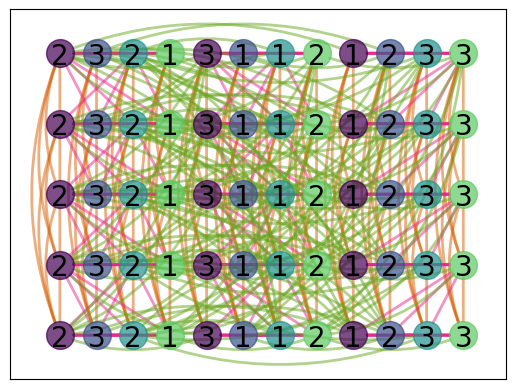

In [199]:
##FULL GRAPH PLOT

color_array = np.zeros((1,4))
for job in task_groups:
    for i,task in enumerate(task_groups[job]):
        color_array[0] = cmap_nodes(job/len(task_groups))
        nx.draw_networkx_nodes(graph, pos_dict, node_size=node_size, nodelist=task, node_color=color_array, alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_curved, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=otm_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=oo_straight, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

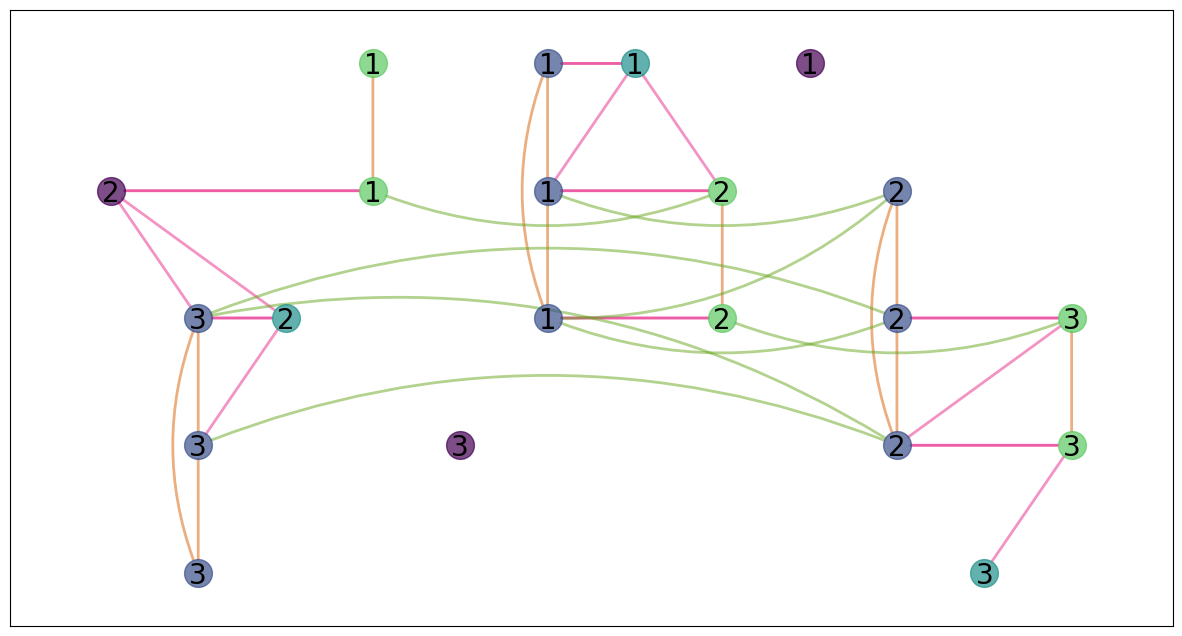

In [200]:
#PRUNED GRAPH PLOT

color_array = np.zeros((1,4))

plt.figure(figsize=(15,8))
for job in task_groups2:
    for i,task in enumerate(task_groups2[job]):
        color_array[0] = cmap_nodes(job/len(task_groups))
        nx.draw_networkx_nodes(graph2, pos_dict2, node_size=node_size, nodelist=task, node_color=color_array, alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph2, pos_dict2, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[0], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[1], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[2], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[3], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

# Embedding

## Target initialization and visualization

In [201]:
#TARGET GRAPH

target = dnx.pegasus_graph(2)

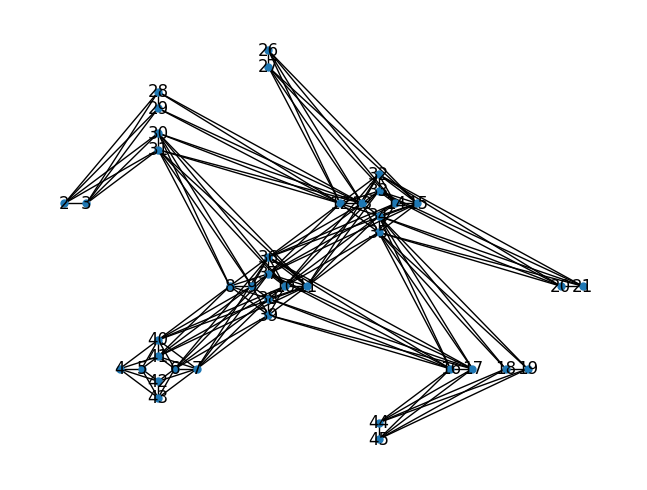

In [202]:
dnx.draw_pegasus(target, node_size=25, crosses=True, with_labels=True)

## DWave default minor-embedding

In [203]:
#DWAVE default minor-embedding

embedding = minorminer.find_embedding(graph2, target)

if len(embedding.keys()) == 0:
    print('Embedding failed')

else:
    print('Embedding succesful')
    e_size = 0
    max_chain = 1

    for k in embedding:
        e_size += len(embedding[k])
        if len(embedding[k]) > max_chain:
            max_chain = len(embedding[k])

    print(f'Embedding size: {e_size}')
    print(F'Max chain: {max_chain}')

Embedding succesful
Embedding size: 24
Max chain: 2


In [214]:
embedding

{(0, 0, 1): [12],
 (0, 3, 1): [30],
 (0, 2, 2): [32],
 (0, 1, 2): [35, 15],
 (0, 1, 4): [20],
 (0, 1, 3): [33],
 (2, 1, 2): [37],
 (2, 1, 3): [41, 11],
 (1, 1, 0): [38],
 (1, 1, 2): [34, 16],
 (1, 1, 1): [39],
 (1, 2, 0): [9],
 (2, 1, 1): [10],
 (1, 3, 1): [8],
 (1, 3, 2): [36],
 (2, 3, 2): [6],
 (2, 3, 3): [7],
 (2, 2, 4): [42],
 (0, 3, 0): [2],
 (1, 0, 3): [28],
 (2, 0, 0): [45]}

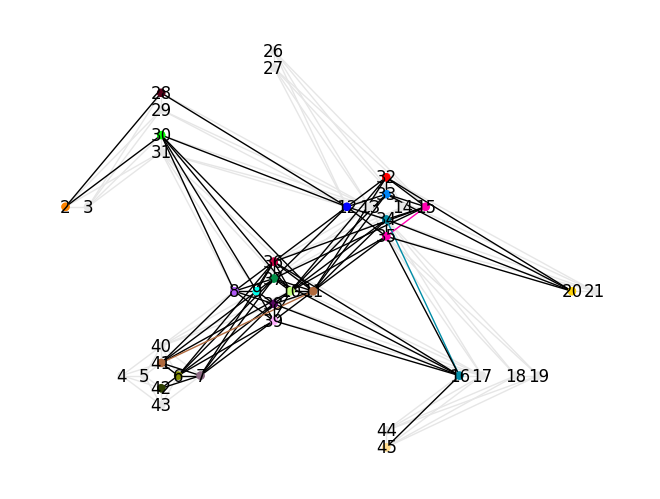

In [205]:
dnx.draw_pegasus_embedding(target, embedding, node_size=25, crosses=True, with_labels=True)

## IP minor-embedding

### Functions

In [61]:
def define_decision_variables(target, graph, model):

    var_dict = {}
    for v in target.nodes:
        for w in graph.nodes:
            var_dict[(v,w)] = model.addVar(vtype=GRB.BINARY, name=f'x_{v},{w}')
    return var_dict

In [62]:
def define_gamma_variables(chains, j, k, var_dict, model):
    ls = []
    for c in chains:
        if len(c) > 0:
            ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))

            s = 1
            for i in range(1, len(c)-1):
                s *= var_dict[c[i],j]
            model.addConstr( ls[-1] == s )

    return ls

In [63]:
def define_delta_p_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y1)] * var_dict[(x2,y2)])
    return delta

def define_delta_o_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y2)] * var_dict[(x2,y1)])
    return delta

In [64]:
def add_size_constraint(var_dict, model, max, min):
    model.addConstr(sum(var_dict.values()) <= max, name='size_constraint')
    model.addConstr(sum(var_dict.values()) >= min, name='size_constraint')

In [65]:
def add_wd_constraint(target, graph, var_dict, model):
    for n in target.nodes:
        tmp = 0
        for k in graph.nodes:
            tmp += var_dict[(n,k)]
        
        model.addConstr(tmp <= 1, name=f'well_defined_constraint_{n}')

In [66]:
def add_fs_constraint(target, graph, var_dict, model, k):
    for n in graph.nodes:
        tmp = 0
        for k in target.nodes:
            tmp += var_dict[k,n]
        
        model.addConstr(tmp <= k, name=f'fiber_size_max_constraint_{n}')
        model.addConstr(tmp >= 1, name=f'fiber_size_min_constraint_{n}')

def add_fs_refinement(target, graph, var_dict, model, k):
    ls = set()
    t_nodes = set(target.nodes)
    for x1 in t_nodes:
        ls.add(x1)
        for x2 in t_nodes-ls:
            chains = list(nx.all_simple_paths(target, x1, x2, k))
            if len(chains) == 0:
                for j in graph.nodes:
                    tmp = var_dict[x1,j] + var_dict[x2,j]
                    model.addConstr(tmp <= 1, name=f'fs_ref_{j}_{x1}_{x2}')

In [67]:
def add_pullback_constraint(target, graph, model, var_dict):
    for ey in graph.edges:
        s = 0
        for ex in target.edges:
            d_p = define_delta_p_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)
            d_o = define_delta_o_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)

            s += d_p+d_o
            model.addConstr(s <= 1, name=f'pullback_ds_{ey}_{ex}')
        model.addConstr(1 <= s, name=f'pullback_{ey}')

In [68]:
def add_fiber_constraint(graph, target, k, var_dict, model):
    for j in graph.nodes:
        ls = set()
        t_nodes = set(target.nodes)
        for x1 in t_nodes:
            ls.add(x1)
            for x2 in t_nodes-ls:

                chains = list(nx.all_simple_paths(target, x1, x2, k))
                if len(chains) > 0:
                    gammas = define_gamma_variables(chains, j, k, var_dict, model)

                    model.addConstr( var_dict[(x1,j)] + var_dict[(x2,j)] + sum(gammas) - 1 <= 2)
            
                

In [221]:
def validate_embedding(embedding, target, graph):

  
  target_edges = list(target.edges)
  valid = True
  used_target_nodes = []
  for node in graph.nodes:

    #edges validation (for every edge (y_1,y_2) there must be an edge
    #(chain(y_1), chain(y_2)) in the target
    neighbors = list(graph.neighbors(node))
    chain_node = embedding[node]
    if len(neighbors) > 0:
      valid = False
      for neig in neighbors:
        chain_neig = embedding[neig]
        for x1 in chain_node:
          for x2 in chain_neig:
            if (x1,x2) in target_edges or (x2,x1) in target_edges:
              valid = True
    
    #check that every chain is made of different nodes
    for n in chain_node:
      if n in used_target_nodes:
        valid = False
      else:
        used_target_nodes.append(n)

    #if the node embedding is not valid return false
    if not valid:
      return False
  
  return True
      


### Execution

In [206]:
#Model initialization
model = gb.Model("minor-embedding", env=env)

max_size = len(target.nodes)
min_size = len(graph2.nodes)
print(f'Min_size: {min_size}')
print(f'Max_size: {max_size}')
k = 1

var_dict = define_decision_variables(target, graph2, model)
model.update()

Min_size: 21
Max_size: 40


In [207]:
var_dict = define_decision_variables(target, graph2, model)

print(f'Decision variables: {len(var_dict)}')

add_size_constraint(var_dict, model, max_size, min_size)
model.update()

c = len(list(model.getConstrs()))
print(f'Size constraints: {c}')

add_wd_constraint(target, graph2, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Well Definition constraints: {c}')

add_fs_constraint(target, graph2, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size constraints: {c}')

add_fs_refinement(target, graph2, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size refinement: {c}')

add_pullback_constraint(target, graph2, model, var_dict)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Pullback constraints: {c}')

add_fiber_constraint(graph2, target, k, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Condition constraints: {c}')



Decision variables: 840
Size constraints: 2
Well Definition constraints: 40
Fiber Size constraints: 44
Fiber Size refinement: 12976
Pullback constraints: 5654
Fiber Condition constraints: 19864


In [208]:
model.Params.timeLimit = 600

Set parameter TimeLimit to value 600


In [209]:
model.setObjective(sum(var_dict.values()), GRB.MINIMIZE)



In [210]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 25518 rows, 16276 columns and 975040 nonzeros
Model fingerprint: 0xf4e641e9
Model has 11152 quadratic constraints
Variable types: 0 continuous, 16276 integer (16276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 20952 rows and 4263 columns
Presolve time: 2.53s
Presolved: 49174 rows, 23165 columns, 661066 nonzeros
Variable types: 0 continuous, 23165 integer (23165 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    

In [212]:
ip_embedding = {}

for j in graph2:
    ip_embedding[j] = []
    for x, y in var_dict:
        if y == j:
            if var_dict[x,j].X > 0.5:
                ip_embedding[j].append(x)

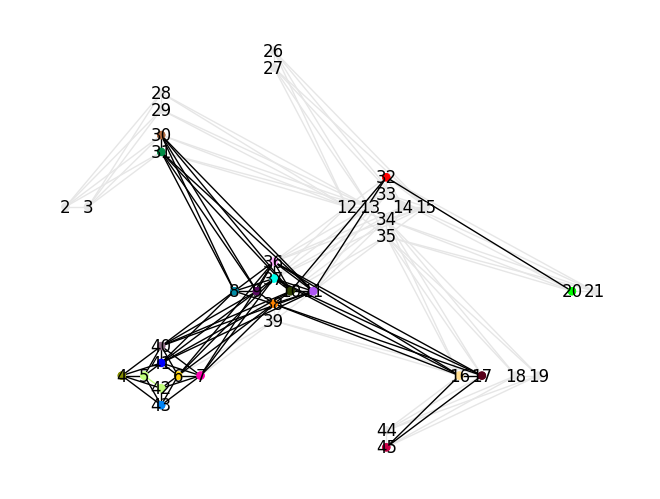

In [215]:
dnx.draw_pegasus_embedding(target, ip_embedding, node_size=25, crosses=True, with_labels=True)

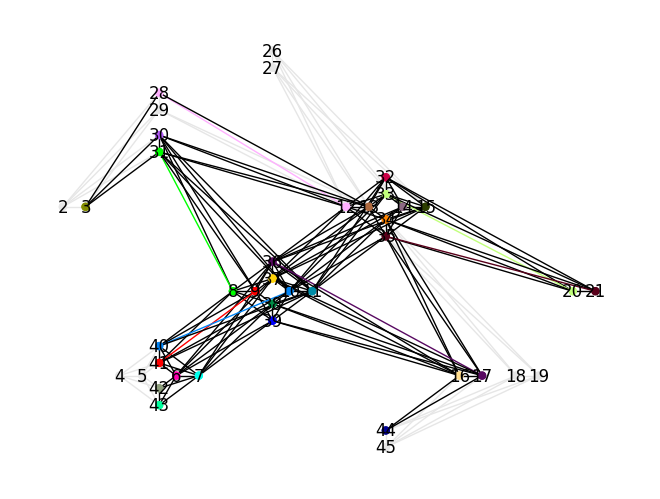

In [156]:
dnx.draw_pegasus_embedding(target, embedding, node_size=25, crosses=True, with_labels=True)

In [216]:
embedding

{(0, 0, 1): [12],
 (0, 3, 1): [30],
 (0, 2, 2): [32],
 (0, 1, 2): [35, 15],
 (0, 1, 4): [20],
 (0, 1, 3): [33],
 (2, 1, 2): [37],
 (2, 1, 3): [41, 11],
 (1, 1, 0): [38],
 (1, 1, 2): [34, 16],
 (1, 1, 1): [39],
 (1, 2, 0): [9],
 (2, 1, 1): [10],
 (1, 3, 1): [8],
 (1, 3, 2): [36],
 (2, 3, 2): [6],
 (2, 3, 3): [7],
 (2, 2, 4): [42],
 (0, 3, 0): [2],
 (1, 0, 3): [28],
 (2, 0, 0): [45]}

In [220]:
validate_embedding(embedding, target, graph2)

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
